# PolSAR data processing using python (on Jupyter Notebook)

### Armando Marino, The University of Stirling, UK

In this practical, you will process  SAOCOM (Argentine Space Agency) data. SAOCOM® product - ©CONAE – (2020). All rights reserved. The images were acquired in 2020 and 2021 near Cordoba, Argentina and these data can be used for training purposes only. They represent a very interesting dataset since they are a time series of quad-polarimetric L-band images. 

In the following, I have pre-processed the images to speed up the work and to make sure the size is not too large for this practical. However, we are also providing the full images that you can pre-process on your own using SNAP
https://catalogos.conae.gov.ar/catalogo/catalogoSatSaocomAdel_en.html. I calibrated the data, made a subset, produced the coherency matrix, co-registered the stack and geocoded the images. 

This practical wil run on MAAP, but I wrote it in a way that you can run it on your machiine at home, once you have downlaoded the data on your computer. This measn, some parts may be less relevant since you are doing it in the cloud.  

## How to run the code
In this practical we are using Jupyter Notebook. This makes the layout of the practical very clear and easy to follow, but the code itself could be run by any other python editors (e.g. Spyder is my favourite).

In jupyter, each of the blocks with a number *In []* on the side is called a **Cell**. 
To run a cell, you can click on it and then click *Ctrl+Enter*.
Once you do this, an asterisks appear inside the brackets... this means that it is processing.

If you want to create a new cell, then click on the left hand side of the cell, this will go from green (Edit mode) to blue (Run mode). Then click "b" and a new sell will appear belove. "d + d" is to delete a cell. 

The cells that do not have a number on the side are Markdown. These are comments from me to you.
Inside a cell with code, the text that follow a "#" are comments, again python will not run those, they are messages for us humans!

In this practical, when you find the word **QUIZ** you need to add some text to fill in the code. The Cell will not run if you don't substitute the correct text to **QUIZ**!



### <span style='color:Blue'> Bringing this to the next level:  
Once you are confident you can run this in jupyter notebook, download the file as .py and run the code in Spider </span>

 # 1. PREPARATION MATTERS
The first step is to import all the libraries that we will be using in our script.

In this practical I reduced to the minimum the number of libraries used. This makes the script easier to run on different machines which may not have all the libraries installed. However when you work on more complex scripts, you may want to take advantage of the large amount of very powerful libraries that are offered by the Python and SAR community.   

In [1]:
# system library
# import sys
# sys.path.insert(0, 'C:\\Programms\\Python\\Libraries\\')
# this library is used to tell python where our functions or libraries are. Since we are workign with a single script, 
# we do not use this library here. But you may want o use it in the future. You need to make sure that the 
# folder is the one containing your user libraries. 

# Numpy is for Numerical manipulations
import numpy as np
# matplotlib.pyplot is for making plots
import matplotlib.pyplot as plt
# scipy.signal is for more complex signal processing manipulations
from scipy import signal
# to do some matrix operations
import math 
# # for using functions raleted to ENVI, if you manage to install this, uncomment the following line, otherwise proceed without
# import spectral.io.envi as envi      

from IPython.display import Image 

# Another useful library is GDAL (which we will not be using here because sometimes is feedly to install on some machines). 

# You can even import your own libraries. To learn more about how to produce your own libraries, have a look at 
# some python tutorials on the internet.


In [2]:
def get_dates_stack(path):
    """
    This module reads the filename of a "formatted" stack and extracts the dates 
    INPUT
    path: folder containing the stacked formatted filenames
    OUTPUT 
    list_dat: the list containing the dates
    """    
    list_names = sorted(os.listdir(path))
    num_acq = len(list_names)
    start = 'T11_'
    end = '.img'
    num_acq = int(len(list_names)/9/2)
    list_date = [None] * num_acq

    j = 0
    for i in range(2*num_acq):
        string = list_names[i]
        if string[-len(end):] == end:
            list_date[j] = string[len(start):-len(end)]
            j = j + 1
            
    return list_date

## 2. DEFINING FUNCTIONS
In the following Cell we want to create all the functions that we will use in this practical. When working on several projects it is strongly suggested that you write all these functions in an external python library. But for the purpose of this practical 
we can just load the functions we need inline with the rest of the code.  

## 2.2 Loading a single image

In [3]:
def Open_ENVI_Image(filename, col, row, dtype):
    """
    This module open binary images 
    The parameters of the functions can be read in the ENVI header file .hdr
    col: number of columns in the image, if left empty takes the values directly from the header
    row: number of raw in the image, if left empty takes the values directly from the header
    dtype: date type, if left empty takes the values directly from the header 
    """
#     # UNCOMMENT the following 3 lines if you manage to install Spectral 
#     lib = envi.open(filename + '.hdr')
#     header =  np.array([lib.ncols, lib.nrows])
#     datatype = lib.dtype

    # COMMENT the following 2 lines if you manage to install Spectral
    header =  np.array([col, row])
    datatype = dtype
    
    # Opening the first image
    f = open(filename + '.img', 'rb')
    img = np.fromfile(f, dtype=datatype)
    
    # The following line is to define the order of pixels in the image.
    # 'C' exploits the order format used in C
    # 'F' exploits the order format used in Fortran
    # If you processed the images in C you can use the following line. If you run this turorial again 
    # using  SNAP with Window the order is normally 'F'. If you see that your images look "scrambled"
    # try using the other format
#     img = img.reshape(header,order='C').astype(dtype)
    img = img.reshape(header,order='F').astype(dtype)

    return(img)

## 2.3 Loading the full covariance matrix
The next function is used to load the quad-pol coherency/covariance matrix for each of the acquisitions. You will recognise it is basically the same code we used for a single acquisition, just generalised using the input string "date". 

In [4]:
def Load_One_Date(path, date):
    """
    This module opens the elements of a coherency matrix for a single acquisition.
    INPUT
    path: a string containing the path to the folder where the images are contained 
    date: a string containing the date of the acquisition we want to open
    OUTPUT 
    The elements of the coherency matrix stored as separate images
    """
    
    ############### Loading T11 ######################################
    # First we need to identify the name of the file for the HH image 
    fileT11 = "T11_" + date
    T11Full = Open_ENVI_Image(path + fileT11, col, row, dtype) 
    # Full stands for the "Entire image"
    # Notice I am calling a function by writing its name and passing the parameters separated by a comma.
    # Always make sure that the order of the parameters is consistent with your definition of the function done above. 
    
    ############### Loading T22 ############################
    fileT22 = "T22_" + date
    T22Full = Open_ENVI_Image(path + fileT22, col, row, dtype) 
    
    ############### Loading T33 ############################
    fileT33 = "T33_" + date
    T33Full = Open_ENVI_Image(path + fileT33, col, row, dtype) 
    
    
    
    ############### Loading T12 ############################
    # The off diagonal terms are cross correlation and therefore they are complex
    # numbers. They are stored by SNAP as Real and Imaginary parts. Both are float numbers.
    fileT12_real = "T12_real_" + date
    T12Full_real = Open_ENVI_Image(path + fileT12_real, col, row, dtype) 
    fileT12_imag = "T12_imag_" + date
    T12Full_imag = Open_ENVI_Image(path + fileT12_imag, col, row, dtype) 
    
    # We can now put the Real and Imaginary parts together to form the complex number
    T12Full = T12Full_real + 1j*T12Full_imag
    # Since the Real and Imaginary part on their own are redundant, we can remove 
    # them from the RAM memory
    del T12Full_real, T12Full_imag
    
    
    ############### Loading T13 ############################
    fileT13_real = "T13_real_" + date
    T13Full_real = Open_ENVI_Image(path + fileT13_real, col, row, dtype) 
    fileT13_imag = "T13_imag_" + date
    T13Full_imag = Open_ENVI_Image(path + fileT13_imag, col, row, dtype) 
    
    T13Full = T13Full_real + 1j*T13Full_imag
    del T13Full_real, T13Full_imag
    
    
    ############### Loading T23 ############################
    fileT23_real = "T23_real_" + date
    T23Full_real = Open_ENVI_Image(path + fileT23_real, col, row, dtype) 
    fileT23_imag = "T23_imag_" + date
    T23Full_imag = Open_ENVI_Image(path + fileT23_imag, col, row, dtype) 
    
    T23Full = T23Full_real + 1j*T23Full_imag
    del T23Full_real, T23Full_imag
    

    return T11Full, T22Full, T33Full, T12Full, T13Full, T23Full


### <span style='color:Blue'> Bringing this to the next level:  
Write these routines into a separate .py file (NOTE: it needs to be .py) and load it as a library. It is possibly easier to do this with Spyder. </span>

## 3. LOADING DATA
Although there are libraries that allow to read SAOCOM images directly (e.g. look at GDAL) in this practical we take an easier approach where we first save the images in binary files (ENVI format) using SNAP, and in Python we read the binary files. 

You can find the binary files in the main folder, their extension is .img (this is the way SNAP calls such binary files, but be careful that other software, e.g. POLSARpro calls them .bin)

### 3.1 Selecting the file path
Notice that in the following I am using the symbol \\ because I am doing this on a Windows machine. Unfortunately, the backslash \ is used by Python to identify special symbols! Therefore Python may mistake the text "\123" as a special symbol.

By using double backslash \\ we tell Python that this is just a backslash \ and not a special symbol.

When you use this on other operative systems (e.g. Linux, which is also teh one used in MAAP), you have no issues because the separator is / which doesn't conflict with python symbols.

In [5]:
# We want first to define the path (folder) where the data are. 
path = "/home/Data/Marino/"
# the above is the folder on my machine, you will need to modify this to include the exact path on your machine.

# it is also useful to have a folder where we can damp some of the results (e.g. images)
path_save = "/home/Data/Marino/out/"

### 3.2 Reading the ENVI header
The information about the format of the binary files is contained in the ENVI header text file (.hdr). You can open it as a common text file. In the following, I am showing you how to set the image parameters that are needed to read the binary files. This information is contained in the header (.hdr) file and if you use the library spectrale, a routine will do this for you. However, if you try this at home and you may struggle installing the library (because it is the first time you work with Pythyon) I still want you to finish this practical. Therefore I am doing something very naughty that I don't suggest you to do as a practice... I am **hardcoding** the image parameters in the following!!! Hardcoding is bad, don't do it, but this allows me to have you concentrating on the code, more than give up because you cannot install a library :)

The following info are for the SAOCOM image we are using in this practical. If you reprocess the data and change the size of the subset, you will need to modify those numbers by looking at the ENVI text header file {.hdr} (that is why you should not hardcode!). The header file can be opened using any text editor.


In [6]:
col = 2782
row = 2372

dtype = '>f4' # this tells that the type is float
# > indicates they are bigger endians

The following cell will take the dates of the data in the folder. The function *get_date_stack* only works with the filename convention that I use, but you can expand on that in case you use a different convention.  
I am commenting this here, because you are in MAAP. Also my experience is that this function may be dependent on the OS used... and I don’t want you to get stuck here on this very IT issue. But please give it a go and if it works prefer this to the (bad) hardcoding solution.

In [7]:
# list_date = get_dates_stack(path)
# num_acq = len(list_date)


list_date = ['2020-02-24', 
             '2021-12-03']
num_acq = len(list_date)


### 3.3 Using a covariance/coherency matrix
The covariance matrix allows to evaluate the second order statistics of the polarimetric targets in the scene.  

The most efficient way to work with POLSAR Covariance matrices is by creating images for each of the elements of the matrix. We will therefore have 6 independent images, one for each element of [C]. When you use the Pauli basis for expressing the scattering vector, we talk about **coherency** matrix.

<span style='color:Blue'> 
    **Question:**   
    How many independent parameters are in these 6 images?  </span>


### 3.4 Preparing the cubes
There are several ways to store multitemporal information. The way I am showing you here is by creating multi-dimensional arrays where the first two dimensions are range and azimuth while the third dimension is time. These three dimensional arrays are sometimes loosely referred to as data cubes. A proper Data Cube is a more complex structure that also allows quick inspection of parts and its use is outside the purpose of this practical. 

When dealing with local processing (i.e., your own machine) of a large dataset, you may encounter problems due to the limited RAM that your machine has. Even if you have a very good computer, there are still limits on how large the dataset can be. A way to combat this limitation is by *block processing*. In this practical we only process a limited subset of the image at a time and store the result in a cube. Then by processing different parts we can mosaic all the scenes together.

Before starting the processing we need to initialise the cubes that will contain our observables (e.g. entropy). If you want to do block processing you should not hardcode the following, but write a for loop that will work its way through all the pixels in the image. You may want to have the block as large as possible but not too big since it will create problems by taking up all your RAM. You can monitor the RAM space used to decide if you can use larger or smaller blocks. Also, you may want to be careful with boundary pixels because with these you will have lower averaging, which is likely to create artifacts (lines at the end of blocks). For the sake of this practical, we are keeping things easier and just using a single block since we are mostly concentrating on the polarimetric processing.

In [8]:
# area to use for cropping the image
# here I only use 500 x 500 pixels but you can enlarge this. 

dr1 = 1500      # starting pixel number for range
dr2 = 2000      # ending pixel number for range
da1 = 1000      # starting pixel number for azimuth
da2 = 1500      # starting pixel number for azimuth


# if you have enough RAM space it may be worth saving the elements of the Pauli basis 
# as well, since they provide interesting physical meaning. 
T11_cube = np.zeros([dr2-dr1, da2-da1, num_acq]) 
T22_cube = np.zeros([dr2-dr1, da2-da1, num_acq]) 
T33_cube = np.zeros([dr2-dr1, da2-da1, num_acq])
T12_cube = np.zeros([dr2-dr1, da2-da1, num_acq],dtype="complex") 
T13_cube = np.zeros([dr2-dr1, da2-da1, num_acq],dtype="complex") 
T23_cube = np.zeros([dr2-dr1, da2-da1, num_acq],dtype="complex")


### <span style='color:Blue'> Explore:  
Try other areas in teh dataset and see if you can find some peculiar target with a "strange" polarimetric behaviour </span>

## 4. Pre-processing images in the stack
We are now ready to start processing the images in the stack. We have 2 images here, that we will be using for change detection. The images are in a covariance matrix format, but we may still do some pre-processing on them before starting the routines dedicated to change detection.

For instance, we want to take some smaller crops of the image and do some filtering. Please note the way I do it in the following is didactic and takes things one step per time, but you can optimise the code by using shortcuts and by combining for loops. My main concern here is that you understand what the code does, so I leave these optimisations to you as future exercise.

In the following I will be using for loop. What this operator does is to repeat the operations inside the loop as many times as we tell it to do. We also need to use a variable that gets iterated every time (generally *i*) to update the loop every time it runs. Another useful tool is a *while* loop and I leave to you to explore what it does :)

In [9]:
# we know that num_acq is the number of images, therefore our for loop as to be repeated num_acq number of times
for i in range(num_acq):
# this say, take the variable i and give it values in the range of 0 to num_acqu. 
# In our case i will be equal to zero in the first iteration,
# and to 1 in the second iteration.
    
    # the following command produces a print out that allows us to know how much processing is missing. 
    print('Processing date ' + str(i+1) + '....... ' + str(num_acq-i-1) + ' dates left.' )
    
    # We can load the images using the function we defined previously
    [T11Full, T22Full, T33Full, T12Full, T13Full, T23Full] = Load_One_Date(path, list_date[i])

    # we want to take a crop of the full image to avoid issues with the limited RAM    
    T11_pre = T11Full[dr1:dr2, da1:da2]           
    T22_pre = T22Full[dr1:dr2, da1:da2]
    T33_pre = T33Full[dr1:dr2, da1:da2]
    T12_pre = T12Full[dr1:dr2, da1:da2]            
    T13_pre = T13Full[dr1:dr2, da1:da2]
    T23_pre = T23Full[dr1:dr2, da1:da2]
    # the ending _pre is used because these images are before the supplementary filtering 
    
    # we can now apply boxcar filtering
    # some people like to have a routine to do the filtering. Here I put the filtering inline, since we apply 
    # a boxcar (wchi is simple), but if you start developing more complex filters it makes sense to have 
    # a library with all these filters inside and you select the specific filtering methodology. 
    # I leave it to you to develop this. 
    win = [7, 7]
    win1 = int(win[0])
    win2 = int(win[1])
    # we need to specify it is an integer np.int() because python can be picky with datatypes when used to
    # identify locations in arrays
    
    # Create the kernel of the boxcar (this is the "template" used for the convolution)
    kernel  = np.ones((win1,win2),np.float32)/(win1*win2)
    # we normalise so that the total power of the kernel is unitary.
    
    # Filter the images using convolve2d
    T11 =  signal.convolve2d(T11_pre, kernel, 
                                  mode='same', boundary='fill', fillvalue=0)
    T22 =  signal.convolve2d(T22_pre, kernel, 
                                  mode='same', boundary='fill', fillvalue=0)
    T33 =  signal.convolve2d(T33_pre, kernel, 
                                  mode='same', boundary='fill', fillvalue=0)
    T12 =  signal.convolve2d(T12_pre, kernel, 
                                  mode='same', boundary='fill', fillvalue=0)
    T13 =  signal.convolve2d(T13_pre, kernel, 
                                  mode='same', boundary='fill', fillvalue=0)
    T23 =  signal.convolve2d(T23_pre, kernel, 
                                  mode='same', boundary='fill', fillvalue=0)
    # The parameter 'same' specifies that the initial and convolved images are forced to have the 
    # same size (the extra pixels produced by the convolution are cut out).
    # The parameter 'fill' specifies that the pixels outside the edge are filled with the fill value 0. If you are not sure how 
    # a covolution works, please ask.    
    
    # we finally save this inside the cubes to be used later.
    T11_cube[:,:,i] = T11
    T22_cube[:,:,i] = T22
    T33_cube[:,:,i] = T33
    T12_cube[:,:,i] = T12
    T13_cube[:,:,i] = T13
    T23_cube[:,:,i] = T23
    
    

Processing date 1....... 1 dates left.
Processing date 2....... 0 dates left.


### <span style='color:Blue'> Bringing this to the next level:  
Create a routine that applies the boxcar filter. 

In GitHub, try to find other filtering methodologies applied to SAR (e.g. Lee refined) and write it here as a routine </span>

## 4.1 Visulisation 

## 4.1 Producing a preliminary RGB image
We want now to have a quick look at the images before we perform any processing. We want to produce Pauli RGB images  
This can be done by asking python to visualise an image containing 3 layers, each one corresponds to a colour, in the order: Red, Green and Blue. 

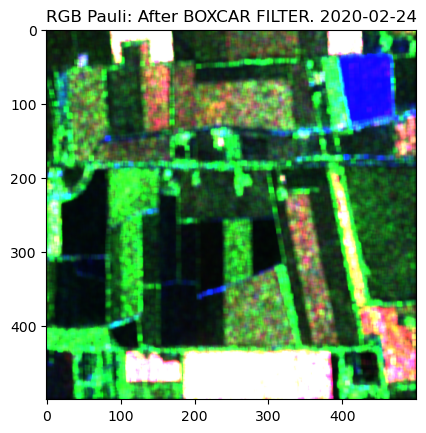

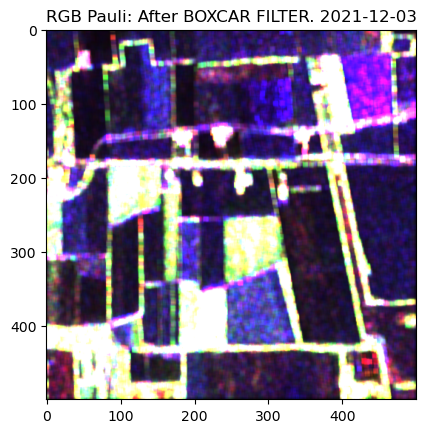

In [10]:
# if you could not save the Pauli elements please change the following line with sizeI = np.shape(T11) and it will plot the last image of the stack 
sizeI = np.shape(T11_cube)            # evaluate the size of each image
dim1 = sizeI[0]       
dim2 = sizeI[1]   
iRGB = np.zeros([dim1, dim2, 3])    # Create an empty 3D array (full of zeros) 

for i in range(num_acq):

    # we assign to the generic arrays T11, T22, and T33, the specific elements of the data cube  
    T11 = T11_cube[:,:,i]
    T22 = T22_cube[:,:,i]
    T33 = T33_cube[:,:,i]

    fact = 1.5       # try different values for this
    iRGB[:,:,0] = T22/(T22.mean()*fact)
    iRGB[:,:,1] = T33/(T33.mean()*fact)
    iRGB[:,:,2] = T11/(T11.mean()*fact)
    iRGB[np.abs(iRGB) > 1] = 1

    # by leaving the argument in parenthesis empty, we just produce a new image
    fig = plt.figure()     
    plt.title('RGB Pauli: After BOXCAR FILTER. ' + list_date[i])     
    plt.imshow(iRGB)

### <span style='color:Blue'> Question:  
What is the information given by the Pauli RGB? 

Looking at the colours we can tell that Blue is mostly related to surface scattering (or odd-bounces), Red is mostly horizontal dihedrals (e.g. double bounce with horizontal corners) and Green is in theory oriented dihedrals (e.g. double bounce with 45 degree corners). However, since oriented objects are relatively rare in scenes, the green is mostly representing random volume scattering. This is because volume scattering is generally depolarised and it is visible in all the polarisation channels.   

### <span style='color:Blue'> Analyse SAOCOM:  
For SAOCOM, why fields look bluer in December and Greener in March?

Please note, the images of March '20 are stacked before December '21. Clearly the plants are not the same because it is a different season, but the land use should be the same allowing us to evaluate the polarimetric trends.
The changes in colour depend on phenology stages of plants. The parcels in this image are mostly covered by corn and soybean:

For corn, when not used for crop rotation, it is planted in September/October and harvested from March to April. This depends on conditions such as rain, frost and soil moisture. When corn is used for crop rotation with potatoes, it is planted in November/December and harvested in April/May.

In relation to soybean, it can be planted in two periods. The first period is between September and November and it is harvested between March and June. The second period is from November to January and is harvested from April to July.

To summarise, in December, we are close to the seeding, the plants are small and we can see the surface scattering underneath (blue colour). In March they are close to harvest, the plants are large and the volume scattering is much stronger (green colour).


## 5. Processing for change detection
Finally!!! we got to the core of this. The next cell will run set of change detectors.
       
Please note, here we consider a simplified version of the Wishart change detections, as you say in the slides. We don't calculate the equivalent number of looks ENL and therefore our distance is only proportional to the actual Wishart algorithm. We do this, because estimating the ENL is very difficult and the estimator normally used is not adequate to produce a good value. To know more search the literature or ask a question. In this practical we leave the issue of setting threshold a part, but please see the slides for more info regarding good strategies to set threshold (e.g. Neyman-Pearson lemma).   


In [11]:
# Initialisations of all the variables that are used in the for loop. 
# Remember: in Python the for loop will not be able to assign a value to an array (e.g. to lam1) if this 
# has not being defined before. It simply does not know where to assign it... 

# the total size of the image after the crop is taken
dim1 = np.shape(T11_cube)[0]
dim2 = np.shape(T11_cube)[1]

T1 = np.matrix(np.zeros([3,3],dtype=np.complex64)) # single pixel covariance matrix for image 1
T2 = np.matrix(np.zeros([3,3],dtype=np.complex64)) # single pixel covariance matrix for image 2
lam1 = np.zeros([dim1,dim2]) # biggest eigenvalue of power difference
lam2 = np.zeros([dim1,dim2])
lam3 = np.zeros([dim1,dim2])
sig1 = np.zeros([dim1,dim2]) # biggest eigenvalue of power ratio
sig2 = np.zeros([dim1,dim2])
sig3 = np.zeros([dim1,dim2])
alpha1 = np.zeros([dim1,dim2]) 
alpha2 = np.zeros([dim1,dim2])
alpha3 = np.zeros([dim1,dim2])
beta1 = np.zeros([dim1,dim2]) 
beta2 = np.zeros([dim1,dim2])
beta3 = np.zeros([dim1,dim2])
a1 = np.zeros([dim1,dim2]) 
a2 = np.zeros([dim1,dim2])
a3 = np.zeros([dim1,dim2])
b1 = np.zeros([dim1,dim2]) 
b2 = np.zeros([dim1,dim2])
b3 = np.zeros([dim1,dim2])

Wishart = np.zeros([dim1,dim2])
trace = np.zeros([dim1,dim2])

eps = 1e-9


# And here it comes the for loop, which covers the full image pixel by pixel
# the first loop runs along the range
for m in range(0, dim1):
    # the second loop runs along the aximuth
    for n in range(0, dim2):
        
        # we load the values of the cubes into the covarianc matrix for pixel [m,n]
        # the first block cover image 1 (index 0)
        T1[0,0] = T11_cube[m,n,0]+eps
        T1[0,1] = T12_cube[m,n,0] 
        T1[0,2] = T13_cube[m,n,0]
        T1[1,0] = np.conj(T12_cube[m,n,0])
        T1[1,1] = T22_cube[m,n,0]+eps
        T1[1,2] = T23_cube[m,n,0]
        T1[2,0] = np.conj(T13_cube[m,n,0])
        T1[2,1] = np.conj(T23_cube[m,n,0])
        T1[2,2] = T33_cube[m,n,0]+eps
        
        # the second block cover image 2 (index 1)
        T2[0,0] = T11_cube[m,n,1]+eps
        T2[0,1] = T12_cube[m,n,1]
        T2[0,2] = T13_cube[m,n,1]
        T2[1,0] = np.conj(T12_cube[m,n,1])
        T2[1,1] = T22_cube[m,n,1]+eps
        T2[1,2] = T23_cube[m,n,1]
        T2[2,0] = np.conj(T13_cube[m,n,1])
        T2[2,1] = np.conj(T23_cube[m,n,1])
        T2[2,2] = T33_cube[m,n,1]+eps

        ####################################################
        # Optimisation for Difference of Covariance matrices
        Tc = (T2 - T1) # Change matrix 

        # The following does the diagonalisation of the chnage matrix.
        # The matrix is symmetric so we can use eigh
        [d1, v1] = np.linalg.eigh(Tc)
        
        ####################################################
        # Optimisation for Power Ratio of Covariance matrices
        # First we find the inverse of T1
        invT1 = np.linalg.inv(T1)
        # Then we run the matrix product to obtain a chnage matrix A
        A = np.matmul(invT1, T2)
        # Finally we diagonalise this
        [d2, v2] = np.linalg.eig(A)
        # Notice I am using eig here because the matrix A is not symmetric
        
        ####################################################        
        # Lets now analyse the EIGENVALUES
        # POWER DIFFERENCE
        # first we want to make sure they are sorted
        # eigh should do this for us, but I always like to make sure that is correct
        ind1 = np.argsort(d1)
        lam1[m,n] = d1[ind1[2]]
        lam2[m,n] = d1[ind1[1]]
        lam3[m,n] = d1[ind1[0]]
        # you see, we are storing the eigenvalues in these images called lam1, lam2 and lam3... pixel per pixel!

        # POWER RATIO
        ind2 = np.argsort(np.abs(d2))
        sig1[m,n] = np.abs(d2[ind2[2]])
        sig2[m,n] = np.abs(d2[ind2[1]])
        sig3[m,n] = np.abs(d2[ind2[0]])
        
        
        ####################################################        
        # Lets now analyse the EIGENVALUES
        # Alpha and beta for Power Difference
        # make sure you remember the equation for alpha
        alpha1[m,n] = np.arccos(np.abs(v1[0,ind1[2]]))
        alpha2[m,n] = np.arccos(np.abs(v1[0,ind1[1]]))
        alpha3[m,n] = np.arccos(np.abs(v1[0,ind1[0]]))
               
        beta1[m,n] = np.arccos(np.abs(v1[1,ind1[2]])/np.sin(alpha1[m,n]))
        beta2[m,n] = np.arccos(np.abs(v1[1,ind1[1]])/np.sin(alpha2[m,n]))
        beta3[m,n] = np.arccos(np.abs(v1[1,ind1[0]])/np.sin(alpha3[m,n]))

        
        # Alpha and beta for Power Ratio
        a1[m,n] = np.arccos(np.abs(v2[0,ind2[2]]))
        a2[m,n] = np.arccos(np.abs(v2[0,ind2[1]]))
        a3[m,n] = np.arccos(np.abs(v2[0,ind2[0]]))
               
        b1[m,n] = np.arccos(np.abs(v2[1,ind2[2]])/np.sin(a1[m,n]))
        b2[m,n] = np.arccos(np.abs(v2[1,ind2[1]])/np.sin(a2[m,n]))
        b3[m,n] = np.arccos(np.abs(v2[1,ind2[0]])/np.sin(a3[m,n]))
    
       ####################################################
        # (proportional) Wishart change detector
        # we need the determinant of the images
        DetT1 = np.linalg.det(T1)
        DetT2 = np.linalg.det(T2)  
        DetT  = np.linalg.det(T1+T2)/2
        # In this implementation we do not consider the numbewr of looks, since their estimation is streightforward and 
        # here we only consider an operator that is proposational to the actual Wishart chnage detector 
        Wishart[m,n] = np.abs(DetT1)*np.abs(DetT2) / np.abs(DetT)**2 

        ####################################################
        # Trace distance
        trace[m,n] = np.abs(np.trace(A))
        
      
    if np.remainder(m,10) == 0:
        print(int(dim1)-m)


# To finalise, it is good to "invert" the images from the Power Ratio to have 
# all images defined between 1 and infinity
sig1[sig1 < 1] = 1/(sig1[sig1 < 1]+1e-5)
sig2[sig2 < 1] = 1/(sig2[sig2 < 1]+1e-5)
sig3[sig3 < 1] = 1/(sig3[sig3 < 1]+1e-5)
# wehen we divide, we should be careful how to deal with zeros. 
# I just like to set them back to zeros as in the follwoing.
sig1[sig1 > 100*sig1.mean()] = 0
sig2[sig2 > 100*sig2.mean()] = 0
sig3[sig3 > 100*sig3.mean()] = 0

500
490
480


/tmp/ipykernel_4993/715357135.py:111: RuntimeWarning: invalid value encountered in arccos
  beta3[m,n] = np.arccos(np.abs(v1[1,ind1[0]])/np.sin(alpha3[m,n]))


470
460
450
440
430
420
410
400
390
380
370
360
350
340
330
320
310
300
290
280
270
260
250
240
230
220
210
200
190
180
170
160
150
140
130
120
110
100
90
80
70
60
50
40
30
20
10


### <span style='color:Blue'> Bringing this to the next level:  
Please note that I run all the detectors "in-line" inside the for loop. You could try to write the different detectors into separate functions inside a library. </span>

## 5.1 Visualising results

### 5.1.1 Power difference

/home/anton/miniconda3/envs/pyrat/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


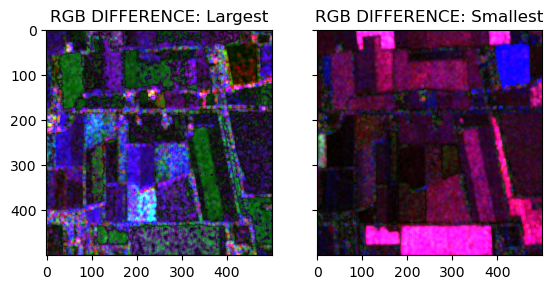

In [12]:
fact = 2 # parameter for contrast enhancement 
fonts = 12     # font size in figures

# we create the RGB for the Maximum of power difference
difM_rgb = np.zeros([dim1,dim2,3])

# we consider root squared of eigenvalues so that the final 
# quantity is comparable with a Magnitude and not an intensity
# like it was an image
sqrtlam1 = np.sqrt(np.abs(lam1))
difM_rgb[:,:,2] = np.cos(alpha1)                * sqrtlam1 
difM_rgb[:,:,0] = np.sin(alpha1)*np.cos(beta1)  * sqrtlam1 
difM_rgb[:,:,1] = np.sin(alpha1)*np.sin(beta1)  * sqrtlam1 
# we have built the three colours based on info from 
# eigenvalues and eigenvectors

difM_rgb[:,:,0] = difM_rgb[:,:,0]/(sqrtlam1.mean()*fact) 
difM_rgb[:,:,1] = difM_rgb[:,:,1]/(sqrtlam1.mean()*fact)
difM_rgb[:,:,2] = difM_rgb[:,:,2]/(sqrtlam1.mean()*fact)
difM_rgb[np.abs(difM_rgb) > 1] = 1


# we repeat for the minimum of the power difference, 
# whcih is likely to be a negative number
# here we consider the absolute value as a measure of its strength
sqrtlam3 = np.sqrt(np.abs(lam3))  
difm_rgb = np.zeros([dim1,dim2,3])
difm_rgb[:,:,2] = np.cos(alpha3)                * sqrtlam3
difm_rgb[:,:,0] = np.sin(alpha3)*np.cos(beta3)  * sqrtlam3
difm_rgb[:,:,1] = np.sin(alpha3)*np.sin(beta3)  * sqrtlam3

difm_rgb[:,:,0] = difm_rgb[:,:,0]/(sqrtlam3.mean()*fact)
difm_rgb[:,:,1] = difm_rgb[:,:,1]/(sqrtlam3.mean()*fact)
difm_rgb[:,:,2] = difm_rgb[:,:,2]/(sqrtlam3.mean()*fact)
difm_rgb[np.abs(difm_rgb) > 1] = 1

# We can make plots where all the images are connected using subplot
# the first 2 arguments say hw many raws and columns our sub-plot has
# than we say we share the x and y axis, so that a zoom in one image 
# produce a zoom in the other image too
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.set_title('RGB DIFFERENCE: Largest', fontsize=fonts)
ax1.imshow(np.abs(difM_rgb))
ax2.set_title('RGB DIFFERENCE: Smallest', fontsize=fonts)
ax2.imshow(np.abs(difm_rgb))



<span style='color:Blue'> 
    **Question:**   
    What are the colour coding telling us here?  </span>

## 5.1.2 Power Ratio

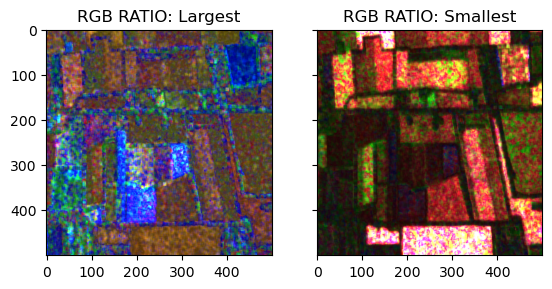

In [13]:
fact2 = 1.5
ratM_rgb = np.zeros([dim1,dim2,3])
sqrtsig1 = np.sqrt(np.abs(sig1))
sqrtsig3 = np.sqrt(np.abs(sig3))  

ratM_rgb[:,:,0] = np.cos(a1)             * sqrtsig1
ratM_rgb[:,:,1] = np.sin(a1)*np.cos(b1)  * sqrtsig1
ratM_rgb[:,:,2] = np.sin(a1)*np.sin(b1)  * sqrtsig1

ratm_rgb = np.zeros([dim1,dim2,3])
ratm_rgb[:,:,2] = np.cos(a3)             * sqrtsig3
ratm_rgb[:,:,0] = np.sin(a3)*np.cos(b3)  * sqrtsig3
ratm_rgb[:,:,1] = np.sin(a3)*np.sin(b3)  * sqrtsig3

ratM_rgb[:,:,0] = ratM_rgb[:,:,0]/(sqrtsig1.mean()*fact2)
ratM_rgb[:,:,1] = ratM_rgb[:,:,1]/(sqrtsig1.mean()*fact2)
ratM_rgb[:,:,2] = ratM_rgb[:,:,2]/(sqrtsig1.mean()*fact2)
ratM_rgb[np.abs(ratM_rgb) > 1] = 1

ratm_rgb[:,:,0] = ratm_rgb[:,:,0]/(sqrtsig3.mean()*fact2)
ratm_rgb[:,:,1] = ratm_rgb[:,:,1]/(sqrtsig3.mean()*fact2)
ratm_rgb[:,:,2] = ratm_rgb[:,:,2]/(sqrtsig3.mean()*fact2)
ratm_rgb[np.abs(ratm_rgb) > 1] = 1


fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.set_title('RGB RATIO: Largest', fontsize=fonts)
ax1.imshow(np.abs(ratM_rgb))
ax2.set_title('RGB RATIO: Smallest', fontsize=fonts)
ax2.imshow(np.abs(ratm_rgb))

<span style='color:Blue'> 
    **Question:**   
    What are the colour coding telling us here?  </span>

### 5.1.3 Wishart

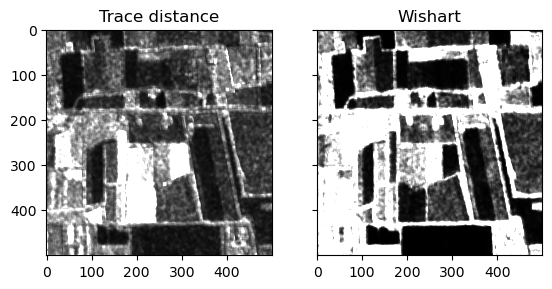

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.set_title('Trace distance', fontsize=fonts)
ax1.imshow(np.abs(trace), vmin = 0, vmax = np.mean(np.abs(trace))*1.5, cmap = 'gray')
ax2.set_title('Wishart', fontsize=fonts)
ax2.imshow(np.abs(Wishart), vmin = 0, vmax = np.mean(np.abs(Wishart))*1.5, cmap = 'gray')

<span style='color:Blue'> 
    **Question:**   
    How the result of the Wishart and HL Trace compare?   </span>

## Interpreting the data
<span style='color:Blue'> 
    Looking at all the results of the chnage detectors, can you draw some conclusiong about the processes that are happening in this dataset?  </span>

